In [1]:
import kagglehub
diabetes_database_path = kagglehub.dataset_download('uciml/pima-indians-diabetes-database')

print('Data source import complete.')


Data source import complete.


In [2]:
import pandas as pd
import os

Data = pd.read_csv(os.path.join(diabetes_database_path, 'diabetes.csv'))

In [3]:
Data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
Data.duplicated().sum()

0

In [6]:
import numpy as np

cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Data[cols_to_fix] = Data[cols_to_fix].replace(0, np.nan)

for col in cols_to_fix:
    Data[col] = Data[col].fillna(Data[col].median())

print("Data after fixing zeros:")
Data.info()

Data after fixing zeros:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


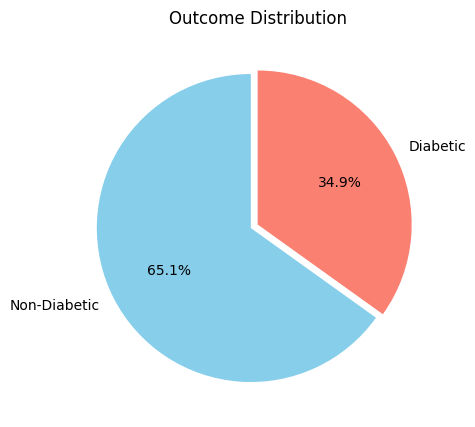

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
plt.pie(Data['Outcome'].value_counts(), labels=['Non-Diabetic', 'Diabetic'],
        autopct='%1.1f%%', startangle=90, explode=(0.05, 0), colors=['skyblue', 'salmon'])
plt.title('Outcome Distribution')
plt.show()


In [8]:
x = Data.drop('Outcome', axis=1)
y = Data['Outcome']

In [9]:
from sklearn.model_selection import train_test_split as splitter

x_val_tra, x_test, y_val_tra, y_test = splitter(x, y, test_size=0.2, random_state=42, stratify=y)
x_tra, x_val, y_tra, y_val = splitter(x_val_tra, y_val_tra, test_size=0.25, random_state=42, stratify=y_val_tra)

In [10]:
# Standarizing Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_tra = scaler.fit_transform(x_tra)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [11]:
# xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score

Model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_lambda=1,
    reg_alpha=0.5,
    scale_pos_weight=(len(y_tra[y_tra == 0]) / len(y_tra[y_tra == 1])),  # handle imbalance
    random_state=42,
    eval_metric='logloss'
)

Model.fit(
    x_tra, y_tra,
    eval_set=[(x_val, y_val)],
    verbose=False
)

# Make predictions on the test set
y_pred = Model.predict(x_test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7532467532467533


In [12]:
!pip install catboost

In [13]:
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

lgbm = lgb.LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

ensemble = VotingClassifier(
    estimators=[('xgb', Model), ('lgbm', lgbm), ('cat', cat)],
    voting='soft'
)
ensemble.fit(x_tra, y_tra)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble.predict(x_test)))
# Make predictions on the test set
y_pred2 = ensemble.predict(x_test)

# Evaluate the model using accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy2}")


[LightGBM] [Info] Number of positive: 160, number of negative: 300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.347826 -> initscore=-0.628609
[LightGBM] [Info] Start training from score -0.628609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [14]:
from sklearn.metrics import classification_report

y_pred_test = ensemble.predict(x_test)
print(classification_report(y_test, y_pred_test, target_names=['Non-Diabetic', 'Diabetic']))

              precision    recall  f1-score   support

Non-Diabetic       0.81      0.83      0.82       100
    Diabetic       0.67      0.63      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



In [15]:
y_pred = ensemble.predict(x_tra)
accuracy = accuracy_score(y_tra, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.991304347826087


In [16]:
import joblib
import zipfile
import os

print("Starting model saving process...")

# 1. Define file names
model_filename = 'diabetes_ensemble_model.joblib'
scaler_filename = 'diabetes_scaler.joblib'
zip_filename = 'diabetes_model_package.zip'

try:
    # 2. Save the ensemble model
    joblib.dump(ensemble, model_filename)
    print(f"Ensemble model saved successfully as: {model_filename}")

    # 3. Save the scaler (CRITICAL for deployment)
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved successfully as: {scaler_filename}")

    # 4. Create a single zip file containing both assets
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(model_filename)
        zf.write(scaler_filename)

    print(f"All assets successfully zipped into: {zip_filename}")

    # 5. (Optional) Clean up the individual files after zipping
    os.remove(model_filename)
    os.remove(scaler_filename)
    print(f"Cleanup complete. Ready for deployment with {zip_filename}")

except Exception as e:
    print(f"An error occurred during saving/zipping: {e}")

Starting model saving process...
Ensemble model saved successfully as: diabetes_ensemble_model.joblib
Scaler saved successfully as: diabetes_scaler.joblib
All assets successfully zipped into: diabetes_model_package.zip
Cleanup complete. Ready for deployment with diabetes_model_package.zip
